# 2022-10-23 • Spike-triggered voltage statistics

What is the spread of the STA at the different times-after-spike.

Motivation: get insight in this signal we're analyzing and fitting / modelling.
Most concretely, what should distribution of errors around prediction be (the default i.e. Normal(0, σₓ)?).

## Imports

In [1]:
#

In [2]:
using MyToolbox

In [6]:
@time_imports using VoltoMapSim

## Data indexing order

We have calculated STA's before.
But we don't want those, we want the individual 'windows'.

Options to index:
1. k → i → tᵣ
2. k → tᵣ → i
3. tᵣ → k → i

where
- tᵣ = t_rel = time after spike
- k  = k, possible connection
- i  = nr of presynaptic spike

Our plot will eventually have tᵣ on the x-axis, and postsyn voltage `v` on the y-axis (and the data is a heatmap of probability) (there'll also be slices, there v is the x-axis, and y is the pdf).

Both these plot types will aggregate (to estimate the pdf's) over both `k` and `i`.

We will separate plots by connection type (inh vs exc vs not-connected).
So `k` will go first -- same as it was with STAs.

Then tᵣ maybe?

## Estimate disk usage

Estimated filesize (it's already 3GB for all STA's of one 10 min sim...)

In [9]:
set_print_precision(4)

In [10]:
mean_fr = 4Hz
duration = 10minute
windows_per_train = mean_fr * duration

2400

In [78]:
samples_per_window = 1000
bytes_per_sample = 64bits / bytes
(window_disk_size = bytes_per_sample * samples_per_window) / kB

8

In [17]:
N_recorded = 50
N_pre_per_post = 3*40
N_conns = N_recorded * N_pre_per_post

6000

In [58]:
# Print with thousands-separator
fmt_bigint(x::Int; sep = ' ') =
    for (digit, i) in Iterators.reverse(zip(digits(x), 1:ndigits(x)))
        if (i % 3 == 0)
            print(sep)  # This will currently print " 100".
        end
        print(digit)
    end

fmt_bigint(x) = Int(x) |> fmt_bigint;

In [66]:
(N_windows = N_conns * windows_per_train) |> fmt_bigint

14 400 000

In [69]:
N_windows * window_disk_size / GB

115.2

Haha. yeah.

So saving them all on disk is not an option.

This is annoying.  

What can we reduce.

Or, we do not save all datapoints, but save some aggregate.\
'The pdf'.\
ig we'd bin then.\
For a given tᵣ, which 1mV wide (e.g.) bin count do we increase.

## Binning strategy

How many bins?

What is the range of a typical STA.

Scratch that, the STA has very small range compared to individual windows.
Those go all the way to spike peak.

But yes we want high density (resolution) in the sta range: -48 mV to -51 mV

Can we have uniform resolution over whole v range, or is that costly.

(The code is easier if uniform resolution).

Algo would look sth like
```python

for (pre, post) in pairs
    for t in pre.spikes
        for tᵣ in window_length
            v = post.voltage[t + tᵣ]
            pdf[pre, post, tᵣ, bin(v)] += 1
```

Size of this pdf / bincounts on disk?

In [77]:
(N_pdfs = N_conns * samples_per_window) |> fmt_bigint

6 000 000

In [88]:
bytes_per_bin = 64bits/bytes  # Just one Int64. (could be Int32 too but eh not worth).
v_peak = 35mV  # Izh parameter
v_min = -90mV  # Guess. (Eᵢ = -80mV). We'd need two bins for if out of range.
v_range = v_peak - v_min;

To get good resolution around STAs (-48 to -51 mV, https://tfiers.github.io/phd/nb/2022-09-01__1144_weights.html#average-sta-window)..

that range should have maybe 1000 bins?\
So 

In [86]:
sta_range = -48mV - -51mV
(v_resolution = sta_range / 1000) / mV

0.003

In [248]:
N_bins = N_bins__uniform_fine = round(Int, v_range / v_resolution) + 2

41669

In [91]:
(disk_size = N_pdfs * N_bins * bytes_per_bin) / GB

2000

Damn.

How is this larger?\
`14 400 000 windows * 8 kB / window`\
vs\
`6 000 000 pdfs * 4 1000 bins * 8 byte / bin`\

Hm, guess it's indeed faster to save values themselves rather than to bin them finely.

We could:
- ~~simulate shorter~~
    - ..but didn't we find that 10' is needed for conntesting
    - ..this won't help for bin disk size, that's already aggregated over spikes (time)
- aggregate over connections, by types
    - only 1000 * 3 pdf's then: exc, inh, unconn
    - you then don't have option to see distr of false-positive conns
- have coarser and/or non-uniform bins
- bin in time also: not 1000 samples per window but e.g. 100. (1 per ms).

For the non-uniform binning, I'd like to see histogram of *all* voltage.

## Voltage histogram

(unconditioned, as in: not external-spike-aligned).

In [92]:
p = get_params(duration = 10minutes, p_conn = 0.04, g_EE = 1, g_EI = 1, g_IE = 4, g_II = 4, ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds), E_inh = -80 * mV, record_v = [1:40; 801:810]);

In [93]:
s = cached(sim, [p.sim]);

Loading cached output from `C:\Users\tfiers\.phdcache\sim\ce5e30aee45561ed.jld2` … done (32.3 s)


In [94]:
s = augment(s, p);

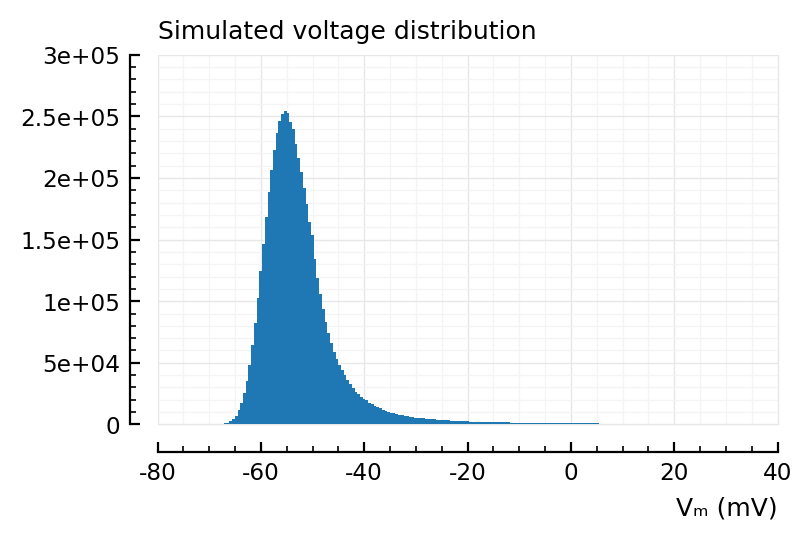

In [244]:
ax, counts, bins, bars = hist(
    s.v[1] / mV,
    bins = 200,
    xlabel = "Vₘ (mV)",
    hylabel = "Simulated voltage distribution"
);

In [240]:
length(bins), length(counts)

(201, 200)

In [241]:
bins[1:2], counts[1]

([-70.32, -69.79], 5)

Interesting, doesn't reach Eᵢ of -80 mV at all.

<br>

In [103]:
bins[end-1:end], counts[end]

([34.47, 35], 311)

Ye that last bin location tracks with izh's v_peak of 35 mV.

`v_thr` is -40 mV (and then there's the slow quadratic runaway).
This distribution might look different around -40 with a more realistic model, like AdEx (EIF).

## Non-uniform bins

To get non uniform bins, we could simply take the ecdf of the above historgram, and invert uniform probability bins.

Problem with non-uniform: comparing pdf's between simulations. Say an AdEx simulation would have other bins.

So we'd need to save the bins found here and use them for all future simulations.

(..but then these bins might not be good for those simulations! They might have a different base-level voltage (say a higher EI input ratio), or have a different tail weight (like exponential vs quadratic spike runoff, presumably)).

In [126]:
@time vcdf = ecdf(s.v[1]);  # Sorts values. Returns a callable

  1.398035 seconds (9 allocations: 91.553 MiB, 2.46% gc time)


In [125]:
extrema(vcdf) ./ mV

(-70.32, 35)

In [118]:
vcdf(-40mV)

0.9384

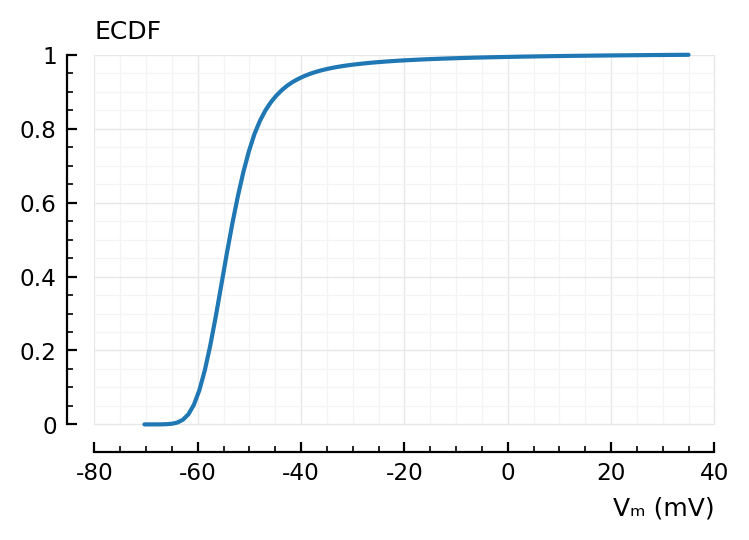

In [168]:
x = range(extrema(vcdf)...; length=100)
plot(x / mV, vcdf.(x); xlabel="Vₘ (mV)", hylabel="ECDF");

We need the inverse, i.e. quantiles, not the ECDF.

In [186]:
nqs = nquantile(s.v[1], 100);

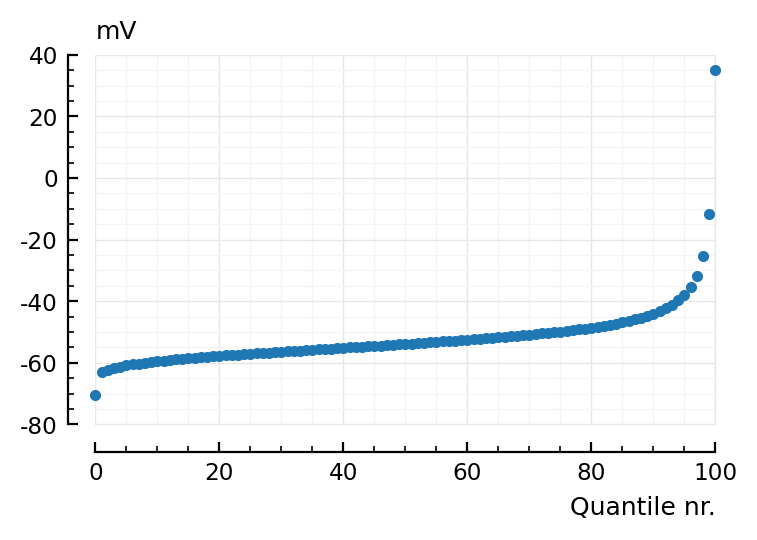

In [187]:
plot(nqs / mV, "."; xlabel="Quantile nr.", hylabel="mV");

In [189]:
qbins = collect(zip(nqs[1:end-1], nqs[2:end]));
@show qbins[1] ./ mV
@show qbins[50] ./ mV
@show qbins[100] ./ mV;

qbins[1] ./ mV = (-70.32, -63.15)
qbins[50] ./ mV = (-54.01, -53.88)
qbins[100] ./ mV = (-11.71, 35)


In [190]:
binsize(bin) = only(diff(collect(bin)))

@show binsize(qbins[1]) / mV
@show binsize(qbins[50]) / mV
@show binsize(qbins[100]) / mV;

binsize(qbins[1]) / mV = 7.168
binsize(qbins[50]) / mV = 0.1295
binsize(qbins[100]) / mV = 46.71


With 100 bins, how big are pdfs on disk?

In [191]:
(N_pdfs * 100 * bytes_per_bin) / GB

4.8

Pfoe! still too large :(

Ok, with aggregating over connection type:

In [245]:
N_pdf_agg_conn = 3 * samples_per_window

3000

In [247]:
N_pdf_agg_conn * 100 * bytes_per_bin / MB

2.4

Ok. That's what we'll do then.

We could have 10x (1000) bins, and still have only 20.4 MB.

What with `N_bins__uniform_fine`? (at 0.003 mV per bin; i.e. so that typical sta range has 1000 bins)

In [251]:
N_bins__uniform_fine

41669

In [253]:
N_pdf_agg_conn * N_bins__uniform_fine * bytes_per_bin / MB

1000

One gig. eh.

I'll go for non-uniform; but more than 100 bins.
And then we need to save these bins, so we can reuse for other simulations.

In [288]:
nquantile_bins(x, n) = begin
    nqs = nquantile(x, n)
    collect(zip(nqs[1:end-1], nqs[2:end]));
end

binsize(bin) = only(diff(collect(bin)))
bin_info(bins, i, unit) = println(
    rpad("Bin $(i): ", 10), rpad(bins[i], 16), " $(unit). ",
    "Width: ", binsize(bins[i]), " $(unit)",
)
bin_info(bins, unit) = begin
    N = length(bins)
    mid = N ÷ 2
    for i in [1, 2, mid-1, mid, mid+1, N-1, N]
        bin_info(bins, i, unit)
    end
end

bin_info(nquantile_bins(s.v[1] / mV, 1000), "mV")

Bin 1:    (-70.32, -65.49) mV. Width: 4.826 mV
Bin 2:    (-65.49, -64.87) mV. Width: 0.6177 mV
Bin 499:  (-53.9, -53.89)  mV. Width: 0.01327 mV
Bin 500:  (-53.89, -53.88) mV. Width: 0.01278 mV
Bin 501:  (-53.88, -53.86) mV. Width: 0.01307 mV
Bin 999:  (18.29, 25.73)   mV. Width: 7.438 mV
Bin 1000: (25.73, 35)      mV. Width: 9.27 mV
